In [1]:
!pip install jiwer

In [2]:
!pip install datasets

In [3]:
!pip install git+https://github.com/huggingface/parler-tts.git

  Cloning https://github.com/huggingface/parler-tts.git to /tmp/pip-req-build-ee6rgrmk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/parler-tts.git /tmp/pip-req-build-ee6rgrmk
  Resolved https://github.com/huggingface/parler-tts.git to commit d108732cd57788ec86bc857d99a6cabd66663d68
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/descriptinc/audiotools to /tmp/pip-install-f3jmoi9r/descript-audiotools_09bc602168f94d7f9b23f2929a03f1e7
  Running command git clone --filter=blob:none --quiet https://github.com/descriptinc/audiotools /tmp/pip-install-f3jmoi9r/descript-audiotools_09bc602168f94d7f9b23f2929a03f1e7
  Resolved https://github.com/descriptinc/audiotools to commit 348ebf2034ce24e2a91a553e3171cb00c0c71678
  Preparing metadata (setup.py) ... done


In [4]:
import torch
from parler_tts import ParlerTTSForConditionalGeneration
from transformers import AutoTokenizer
import soundfile as sf
from IPython.display import Audio

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_tts = ParlerTTSForConditionalGeneration.from_pretrained("parler-tts/parler-tts-mini-jenny-30H").to(device)
tokenizer_tts = AutoTokenizer.from_pretrained("parler-tts/parler-tts-mini-jenny-30H")

sr = model_tts.config.sampling_rate

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_ra

In [5]:
def get_audio(text, return_audio=False):
    description = "Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality."

    prompt = tokenizer_tts(text, return_tensors="pt").input_ids.to(device)

    input_ids = tokenizer_tts(description, return_tensors="pt").input_ids.to(device)

    generation = model_tts.generate(input_ids=input_ids, prompt_input_ids=prompt)
    generation = generation.cpu().numpy().squeeze()
    if return_audio:
        return Audio(generation, rate=sr)
    return generation

# Выбор метрик
В задаче TTS не существует единой метрики, которая говорит о качестве модели. Первая метрика, которая приходит в голову - оценка человека.
## 1. Субъективная человеческая оценка.

In [7]:
get_audio(
    "World War 2 began in 1939. 2 + 2 = 5" , return_audio=True
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [8]:
get_audio(
    "IBM (International Business Machines Corporation) is a multinational" +
    " technology company headquartered in Armonk, N.Y.", return_audio=True
)

In [9]:
get_audio(
    "regions of nascent polypeptides to prevent aggregation ",
    return_audio=True
) # модель плохо произносит слово polypeptides

In [10]:
get_audio(
    "I raly enjooy readding books and larning new thngs" +
    "becase it hep me to imprve my skils.",
    return_audio=True
)

После проведенного анализа работы модели выявлены некоторые особенности. Ниже приведет список того, в чем модель себя плохо проявила:
1. Модель плохо справляется с озвучиванием каких-либо математических объектов, например: чисел (будь-то даты, возраст и так далее), операций (умножение, возведение в степень и так далее).
2. Модель плохо справляется с аббревиатурами.
3. Модель плохо справляется со сложно терминологией, пресущей каким-то отдельным областям (возможно, потому что модель не видела эти примеры в обучающей выборке).

Теперь отметим то, на чем модель хорошо себя проявила:
1. Модель отлично справляется с опечатками в тексте (возможно, потому что опечатки имели место быть в обучающей выборке).

##2. WER
Метрика WER показывает, насколько два текста отличаются друг от друга. Для оценки нашей модели с помощью этой метрики необходимо использовать следующий пайплайн:
1. Сгенерируем текстовый датасет с помощью GPT-2 на различные темы.
2. На текстовом датасете прогоним Parler-TTS.
3. Получившиеся аудио конвертируем в текст с помощью модели openai/whisper-large-v3-turbo.
4. Посчитаем WER между оригинальным текстом и текстом на выходе ASR модели.

Стоит отметить, что данная метрика не совсем честно показывает WER, так как имеет место быть ошибко ASR модели.

In [14]:
from metrics.wer import WER

wer_metric = WER(dataset_size=20)
wer_metric.count_wer_conf_interval(sr, get_audio)

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
  5%|▌         | 1/20 [00:03<00:58,  3.08s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
 10%|█         | 2/20 [00:06<00:58,  3.25s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
 15%|█▌        | 3/20 [00:09<00:53,  3.14s/it]The attention mask and the pad token id were not set. As a consequence, yo

(0.10468910329751005, 0.22375924408862766)

In [15]:
wer_metric.count_wer(sr, get_audio)

0.16422417369306885

## 3. Inference speed
Проблема тяжеловесных моделей заключается в том, что у них очень долгий инференс. Соответственно, хорошей метрикой для модели будет скорость инференса. В коде ниже было решено отобрать одинаковое по длине токенов количество примеров для всех возможных длин токенов из заданного диапазона. В качестве датасета использовался тренировочный датасет.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 20978/20978 [00:42<00:00, 497.63it/s] 


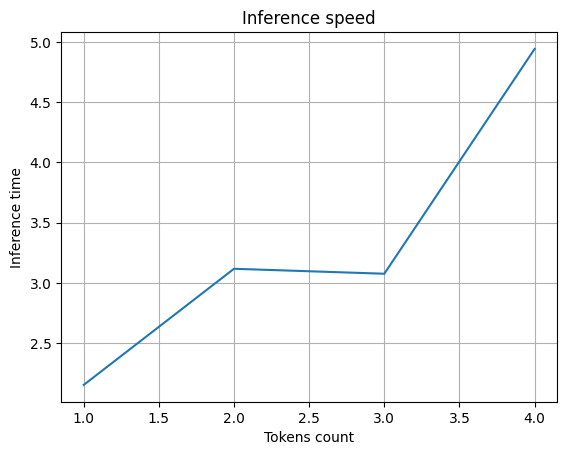

In [17]:
from metrics.inference_speed import InferenceSpeed


metric = InferenceSpeed(get_audio, num_samples=2, max_text_len=5)
metric.plot_inference_speed()

## 4. Audio similarity
Завершающей метрикой будет сравнение мелспектральных диаграмм сигналов оригинала и сгенерированного моделью.

In [18]:
import librosa


def get_audio_mel(text):

    description = "Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality."

    prompt = tokenizer_tts(text, return_tensors="pt").input_ids.to(device)

    input_ids = tokenizer_tts(description, return_tensors="pt").input_ids.to(device)

    generation = model_tts.generate(input_ids=input_ids, prompt_input_ids=prompt)
    generation = generation.cpu().numpy().squeeze()

    mel = librosa.feature.melspectrogram(y=generation, sr=sr)
    return mel


In [19]:
from metrics.audio_similarity import AudioSimilarity


metric_similarity = AudioSimilarity(metric.dataset, get_audio_mel)

In [20]:
metric_similarity.count_similarity_conf_interval()

100%|██████████| 100/100 [17:26<00:00, 10.47s/it]


(0.11154110740498106, 0.13029463948480277)

In [21]:
metric_similarity.count_similarity()

0.12091787344489191